<a href="https://colab.research.google.com/github/manm0han/bank_marketing_effectiveness/blob/main/Bank_Marketing_Effectiveness_Prediction_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <b><u> Project Title : Predicting the effectiveness of bank marketing campaigns </u></b>

## <b> Problem Description </b>

### The data is related with direct marketing campaigns (phone calls) of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed. The classification goal is to predict if the client will subscribe a term deposit (variable y).


## <b> Data Description </b>

## <b>Input variables: </b>
### <b> Bank Client data: </b>

* ### age (numeric)
* ### job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
* ### marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
* ### education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
* ### default: has credit in default? (categorical: 'no','yes','unknown')
* ### housing: has housing loan? (categorical: 'no','yes','unknown')
* ### loan: has personal loan? (categorical: 'no','yes','unknown')

### <b> Related with the last contact of the current campaign:</b>
* ### contact: contact communication type (categorical: 'cellular','telephone')
* ### month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
* ### day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
* ### duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

### <b>Other attributes: </b>
* ### campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
* ### pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
* ### previous: number of contacts performed before this campaign and for this client (numeric)
* ### poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


### <b>Output variable (desired target):</b>
* ### y - has the client subscribed a term deposit? (binary: 'yes','no')

**Import Data:**

In [59]:
# Importing pandas and numpy
import pandas as pd
import numpy as np

# Importing libraries for graphing
import matplotlib.pyplot as plt
import seaborn as sns

#Importing XGBoost and other scikit libraries
import xgboost
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_auc_score
from sklearn import ensemble

In [2]:
#Mounting the drive to get data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Reading the data
df = pd.read_csv('/content/drive/MyDrive/Almabetter/Classification capstone project/Copy of bank-full.csv', delimiter = ';')

**Exploratory Data Analysis:**

In [4]:
# Viewing the dataset
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [5]:
df.shape

(45211, 17)

The dataset has   rows

Null Values:

In [6]:
#Checking for null values
df.isnull().values.any()

False

We can see that there are no null values in the dataset.

Univariate analysis:

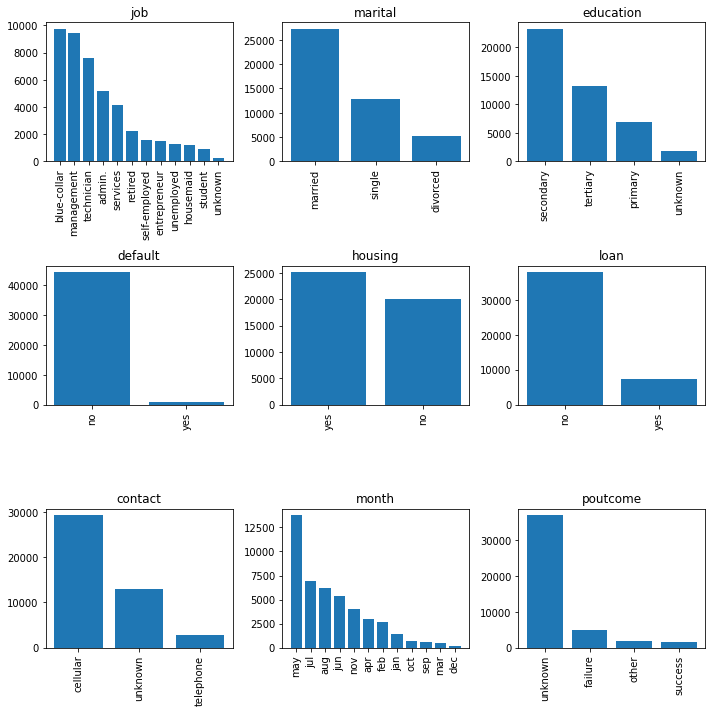

In [7]:
# Univariate analysis of categorical columns
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(10,10))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1
fig.tight_layout()
plt.show()

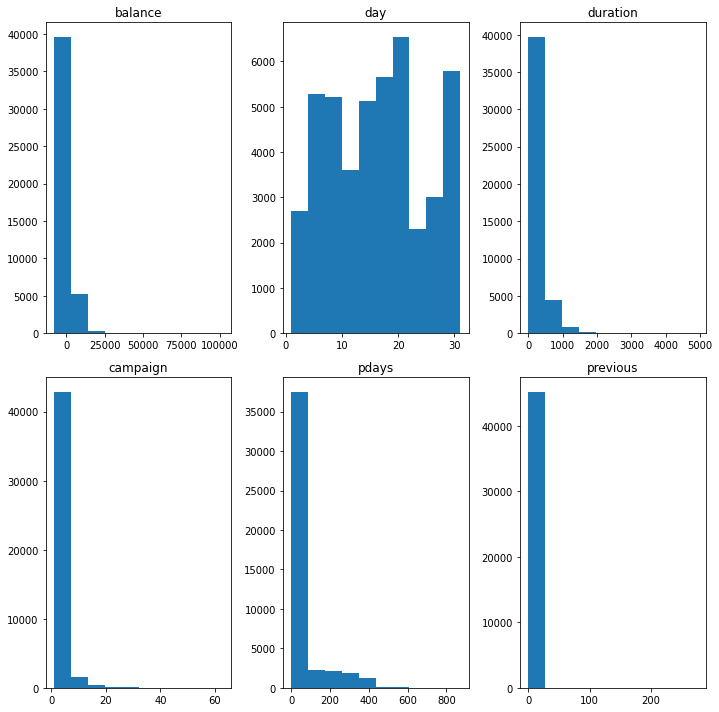

In [8]:
# Univariate analysis of numerical columns
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(10,10))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1
fig.tight_layout()
plt.show()

We can see that campaign, pdays and previous columns have outliers. Therefore, we need to investigate these columns further.

In [9]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,45211.000000,45211.000000,45211.000000
mean,40.197828,2.763841,0.580323
std,100.128746,3.098021,2.303441
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,-1.000000,3.000000,0.000000
max,871.000000,63.000000,275.000000


pdays column has a value of -1 which has no meaning since days can't be negative. So before we remove this lets look at the distribution of this value.

In [10]:
df['pdays'].value_counts()

-1      36954
 182      167
 92       147
 91       126
 183      126
        ...  
 449        1
 452        1
 648        1
 595        1
 530        1
Name: pdays, Length: 559, dtype: int64

-1 in pdays occurs 36954 times which is more than half of the total rows so it will be best if we delete this column.

Percentage of 'campaign' values above 34:

In [11]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.059719979650969895

Campaign tells us how many calls were made to this client. Since 34 is a relatively high number of calls as per this data we can consider them as outliers.

Percentage of 'previous' values above 34:

In [12]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.024330362080024773

Like for the campaign column, previous column means the number of calls for the previous campaign. Again, above 34 are clearly outliers.

Let's look at the distribution of values in the target column 'y'.

In [13]:
value_counts = df['y'].value_counts()

In [14]:
value_counts

no     39922
yes     5289
Name: y, dtype: int64

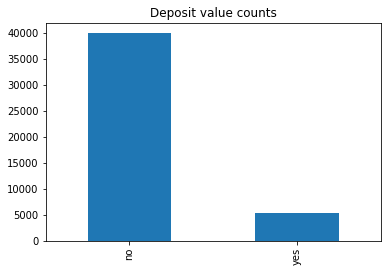

In [15]:
value_counts.plot.bar(title = 'Deposit value counts')

Bivariate analysis of categorical variables:

1. Job vs y

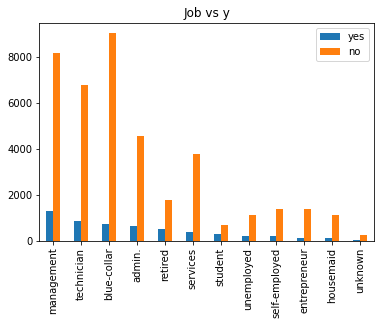

In [16]:
j_df = pd.DataFrame()
j_df['yes'] = df[df['y'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['y'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job vs y')

2. Marital status vs y

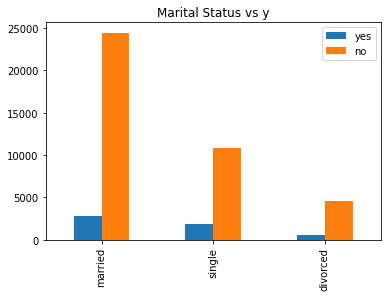

In [17]:
j_df = pd.DataFrame()
j_df['yes'] = df[df['y'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['y'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital Status vs y')

3. Education vs y

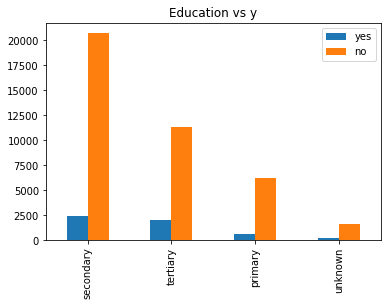

In [18]:
j_df = pd.DataFrame()
j_df['yes'] = df[df['y'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['y'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education vs y')

4. Type of contact vs y

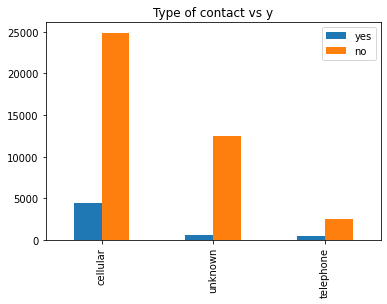

In [19]:
j_df = pd.DataFrame()
j_df['yes'] = df[df['y'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['y'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact vs y')

From the above diagrams we can make the following inferences:
1. Customers working blue collar jobs are less likely to subscribe whereas management and technicians are more likely.
2. Single customers are more likely to subscribe for a term deposit whereas married customers are less likely.
3. Customers with tertiary education are more likely to subscribe whereas customers with secondary education are less likely to subscribe.

Bivariate analysis of numerical variables:

1. Balance vs y

In [20]:
b_df = pd.DataFrame()

b_df['balance_yes'] = (df[df['y'] == 'yes'][['y','balance']].describe())

b_df['balance_no'] = (df[df['y'] == 'no'][['y','balance']].describe())

b_df

,balance_yes,balance_no
count,5289.000000,39922.000000
mean,1804.267915,1303.714969
std,3501.104777,2974.195473
min,-3058.000000,-8019.000000
25%,210.000000,58.000000
50%,733.000000,417.000000
75%,2159.000000,1345.000000
max,81204.000000,102127.000000


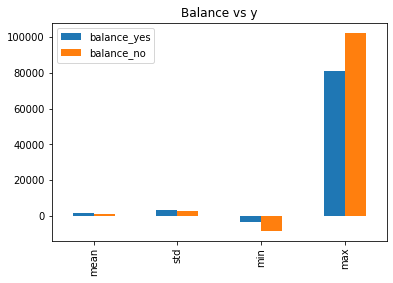

In [21]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance vs y')

2. Age vs y

In [22]:
a_df = pd.DataFrame()

a_df['age_yes'] = df[df['y'] == 'yes'][['age', 'y']].describe()
a_df['age_no'] = df[df['y'] == 'no'][['age', 'y']].describe()

In [23]:
a_df

,age_yes,age_no
count,5289.000000,39922.000000
mean,41.670070,40.838986
std,13.497781,10.172662
min,18.000000,18.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,95.000000


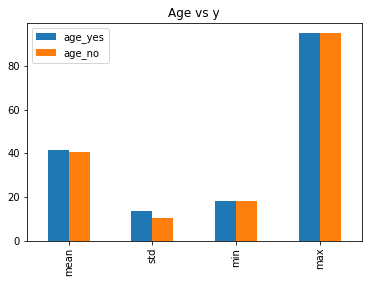

In [24]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age vs y')

3. Number of contacts performed during this campaign vs y

In [25]:
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['y'] == 'yes'][['y','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['y'] == 'no'][['y','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,5289.000000,39922.000000
mean,2.141047,2.846350
std,1.921826,3.212767
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


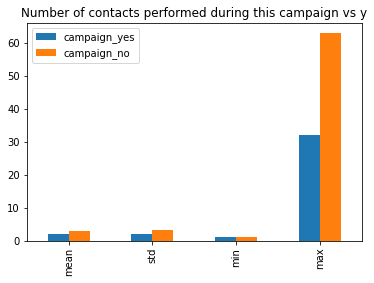

In [26]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign vs y')

4. Number of contacts performed during previous campaign and deposit statistics

In [27]:
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['y'] == 'yes'][['y','previous']].describe())['previous']
p_df['previous_no'] = (df[df['y'] == 'no'][['y','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,5289.000000,39922.000000
mean,1.170354,0.502154
std,2.553272,2.256771
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,58.000000,275.000000


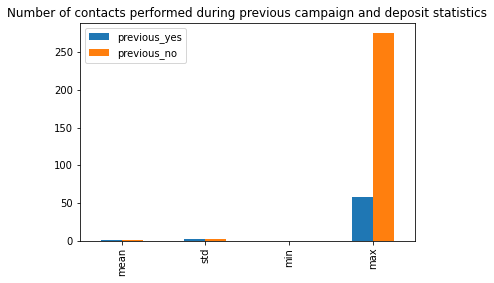

In [28]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

**Feature engineering:**

In [29]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'y']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    
    return cleaned_df

In [30]:
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,y_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,58,2143,5,261,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
1,44,29,5,151,0,1,0,0,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0
2,33,2,5,76,0,1,1,0,0,1,...,0,1,0,0,0,0,0,1,1.0,0.0
3,47,1506,5,92,0,1,0,0,1,0,...,0,1,0,0,0,0,0,1,1.0,0.0
4,33,1,5,198,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,1.0,0.0


**Machine Learning using XGBoost:**

In [31]:
X = cleaned_df.drop(columns = 'y_bool')
y = cleaned_df[['y_bool']]

In [32]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [33]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

In [34]:
# Train XGBoost model
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for the above mentioned 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.937: test: 0.906


This is an excellent score for our model. We only need to look at accuracy because false positives and negatives are not important in this particular business case.

In [51]:
train_auc = roc_auc_score(y_train,y_train_preds)
test_auc = roc_auc_score(y_test,y_test_preds)

In [52]:
train_auc

0.7913212179343325

In [53]:
test_auc

0.7166385798561087

From the above result we can see that our model is able to classify well. However, we will look at one more model and see if it can give us better results.

**Random Forest Classifier:**

In [55]:
# Number of trees
n_estimators = [50,80,100]

# Maximum depth of trees
max_depth = [4,6,8]

# Minimum number of samples required to split a node
min_samples_split = [50,100,150]

# Minimum number of samples required at each leaf node
min_samples_leaf = [40,50]

# HYperparameter Grid
param_dict = {'n_estimators' : n_estimators,
              'max_depth' : max_depth,
              'min_samples_split' : min_samples_split,
              'min_samples_leaf' : min_samples_leaf}

In [56]:
param_dict

{'max_depth': [4, 6, 8],
 'min_samples_leaf': [40, 50],
 'min_samples_split': [50, 100, 150],
 'n_estimators': [50, 80, 100]}

In [61]:
# Create an instance of the RandomForestClassifier
rf_model = RandomForestClassifier()

# Grid search
rf_grid = GridSearchCV(estimator=rf_model,
                       param_grid = param_dict,
                       cv = 5, verbose=2, scoring='roc_auc')

rf_grid.fit(X_train,y_train)

Fitting 5 folds for each of 54 candidates, totalling 270 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=4, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   2.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   1.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=6, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   2.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=80; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   3.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   2.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.7s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=100, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=50; total time=   1.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   2.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   2.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=40, min_samples_split=150, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   1.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   1.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   2.2s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=80; total time=   1.4s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=50, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.9s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=100, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=50; total time=   0.8s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=80; total time=   1.3s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   2.1s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   2.0s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.5s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


[CV] END max_depth=8, min_samples_leaf=50, min_samples_split=150, n_estimators=100; total time=   1.6s


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [4, 6, 8], 'min_samples_leaf': [40, 50],
                         'min_samples_split': [50, 100, 150],
                         'n_estimators': [50, 80, 100]},
             scoring='roc_auc', verbose=2)

In [62]:
rf_grid.best_estimator_

RandomForestClassifier(max_depth=8, min_samples_leaf=50, min_samples_split=100)

In [63]:
rf_optimal_model = rf_grid.best_estimator_

In [64]:
rf_grid.best_params_

{'max_depth': 8,
 'min_samples_leaf': 50,
 'min_samples_split': 100,
 'n_estimators': 100}

In [65]:
# Making predictions on train and test data

train_class_preds = rf_optimal_model.predict(X_train)
test_class_preds = rf_optimal_model.predict(X_test)


# Get the probabilities on train and test
train_preds = rf_optimal_model.predict_proba(X_train)[:,1]
test_preds = rf_optimal_model.predict_proba(X_test)[:,1]

In [66]:
# Calculating accuracy on train and test
train_accuracy = accuracy_score(y_train,train_class_preds)
test_accuracy = accuracy_score(y_test,test_class_preds)

print("The accuracy on train dataset is", train_accuracy)
print("The accuracy on test dataset is", test_accuracy)

The accuracy on train dataset is 0.8969886561127437
The accuracy on test dataset is 0.8953111176644057


The accuracy is not as good as before but is sufficiently good.

In [67]:
# Get the confusion matrices for train and test
train_cm = confusion_matrix(y_train,train_class_preds)
test_cm = confusion_matrix(y_test,test_class_preds )

In [68]:
train_cm

array([[27804,   152],
       [ 3108,   583]])

In [69]:
test_cm

array([[11885,    81],
       [ 1339,   259]])

In [72]:
# Get the roc_auc score for train and test dataset
train_auc = roc_auc_score(y_train,train_preds)
test_auc = roc_auc_score(y_test,test_preds)

In [73]:
train_auc

0.9179429268402927

In [74]:
test_auc

0.9088781376185384

However, for random forest model the roc_auc score is much better and so it is advisable to use this model for predictions.

**Conclusion:**

With an accuracy of 89.5 percent and an roc_auc score of 90.88 percent we can confidently use this model to predict whether the customer will subscribe or not even before the call is made. This will save time and resources as we have to only call the customers who are more likely to subscribe thereby reducing the workload of the marketing team.